<h1> Classificatore di X</h1>

## Obiettivi
---

Date due o più persone e un tweet cercheremo di stabilire chi dei due è più probabile lo abbia detto. Per far questo dovremo:
- Fornire un metodo che crei una lista di Tweet usando  dataset scaricati da kaggle
- Preprocessare i nostri dati usando NLP
- Fornire un classificatore
- Classificare nuovi tweet in base ai dati già conosciuti

## Contenuto di questo file
---

Mostreremo un primo esempio usando una lista di tweet di Trump e Hillary Clinton così da spiegare cosa fa il codice e come si comporta la classificazione basata su regressione logistica.

Successivamente mostreremo come funziona il nostro script in caso abbiamo più di 2 etichette (aggiungeremo i tweet di Barack Obama).

Faremo anche delle comparazioni tra Random Forest,regressione logistica, KNN e Naive Bayes Multinomiale sia con 2 che con 3 etichette.

Infine, verrà fornito il codice completo del software con caratteristiche aggiuntive (come per esempio indicare utenti diversi da Trump e Hillary Clinton o scegliere un particolare classificatore).

# Creiamo il dataset unendo i due dataframe scaricati da kaggle 
fonte: 

-https://www.kaggle.com/datasets/benhamner/clinton-trump-tweets 

-https://www.kaggle.com/datasets/austinreese/trump-tweets

-https://www.kaggle.com/datasets/neelgajare/all-12000-president-obama-tweets

In [9]:
import numpy as np
import pandas as pd
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

percorso_file_csv = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(percorso_file_csv.format(hillary))
percorso_file_csv = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(percorso_file_csv.format(trump))

dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

In [10]:
dataset.shape

(4962, 6)

## Preprocessiamo i tweet e creiamo un modello

---

Per poter fare la classificazione dobbiamo creare una funzione di rappresentazione che converta i tweet in esempi (array di feature).

**Dovremo quindi:**
- Rappresentare i dati in forma vettoriale.
- Inizializzare un modello.
- Ottimizzare gli iperparametri.
- Training e fitting del modello ottimizzato.
- Valutare le performance del modello.

In [11]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

def clean_tweet_nltk(raw_data):
    tknzr = TweetTokenizer()
    stop_words = set(stopwords.words('english'))

    cleaned_data = []

    for tweet in raw_data:
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Remove user handles
        tweet = re.sub(r'@[^\s]+', '', tweet)
        # Tokenize the tweet
        tokens = tknzr.tokenize(tweet)
        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in stop_words]
        # Join the tokens back into a string
        cleaned_tweet = ' '.join(tokens)
        cleaned_data.append(cleaned_tweet)

    return cleaned_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\orazi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
tweet_text = dataset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

In [13]:
print(tweet_text[0:9])

["I don't know Putin have no deals in Russia and the haters are going crazy - yet Obama can make a deal with Iran #1in terror no problem!"
 '@mintimm @kenscudder Congratulations x2, Mini! Such wonderful news.'
 'I hearby demand a second investigation after Schumer of Pelosi for her close ties to Russia and lying about it. https://t.co/qCDljfF3wN'
 '@Hasbro Thank you. 🙏'
 '@tarabea80 @BillClinton What kind words Tara. It was great meeting you last night, and thanks for writing!'
 '@KatieS @MoxxieVentures This is exciting, Katie. Congratulations—and love the name!'
 'I hear by demand a second investigation after Schumer of Pelosi for her close ties to Russia and lying about it. https://t.co/qCDljfF3wN'
 '@itsmebeccam @TATLGDoc I’m so proud of you Rebecca. And you should be proud of all you’ve accomplished. There’s a bright future ahead!'
 "@KLSecondCity Please pass on to Nora that I'm thinking of her, rooting for her, and a proud member of #TeamNora."]


In [14]:
print(clean_text[0:9])

['know Putin deals Russia haters going crazy - yet Obama make deal Iran #1in terror problem !', 'Congratulations x2 , Mini ! wonderful news .', 'hearby demand second investigation Schumer Pelosi close ties Russia lying .', 'Thank . 🙏', 'kind words Tara . great meeting last night , thanks writing !', 'exciting , Katie . Congratulations — love name !', 'hear demand second investigation Schumer Pelosi close ties Russia lying .', '’ proud Rebecca . proud ’ accomplished . ’ bright future ahead !', "Please pass Nora I'm thinking , rooting , proud member #TeamNora ."]


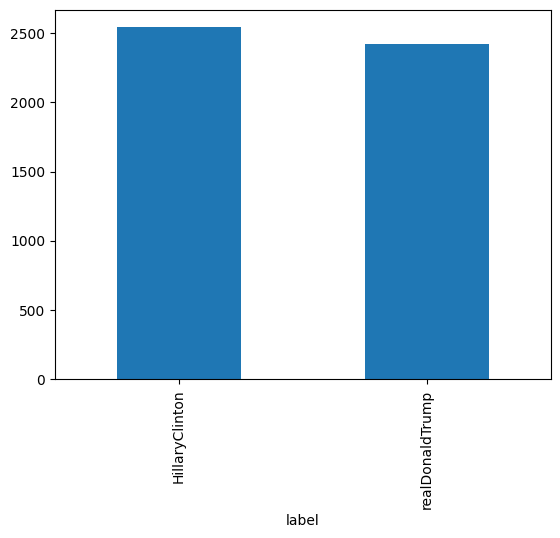

In [15]:
#Plottiamo il grafico dei tweet per etichetta
from matplotlib import pyplot as plt
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

Training Set


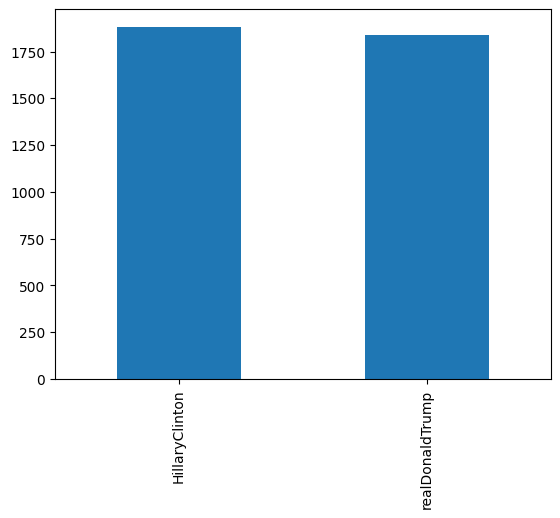

Test Set


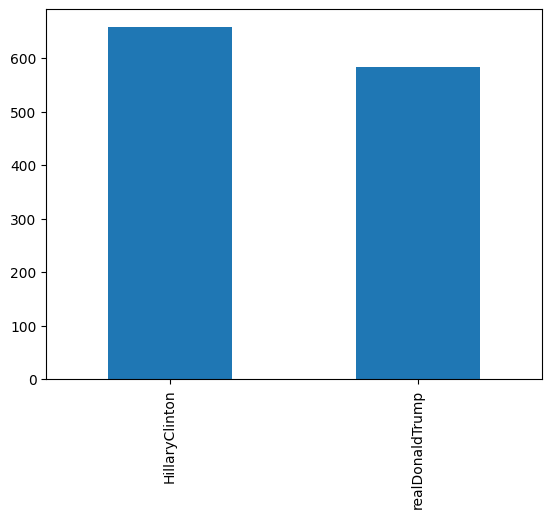

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

print("Training Set")
pd.Series(y_train_set).value_counts().plot.bar()
plt.show()

print("Test Set")
pd.Series(y_test_set).value_counts().plot.bar()
plt.show()

Ora creiamo il classificatore. Useremo come primo esempio un classificatore basato su **regressori logistici**. Useremo le classi **CountVectorizer** e **TfidfTransformer** per creare una rappresentazione vettoriale di ogni tweet e associare ad ogni feature di ciascuna rappresentazione un valore normalizzato con tf-idf.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from stop_words import get_stop_words 

eng_stop_words = get_stop_words('english')
ita_stop_words = get_stop_words('italian')
list_stop_words = eng_stop_words + ita_stop_words

count_vect = CountVectorizer(ngram_range=(1,4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer(use_idf=True)
log = LogisticRegression(solver='liblinear')

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

print(log.fit(x_train, y_train_set))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'avra', 'avro', 'can', 'couldn', 'didn', 'doesn', 'don', 'fara', 'faro', 'giu', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'perche', 'pero', 'piu', 're', 'sara', 'saro', 'shan', 'shouldn', 'stara', 'staro', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


LogisticRegression(solver='liblinear')


In [18]:
y_train_preds = log.predict(x_train)
y_test_preds = log.predict(x_test)

## Valutiamo il funzionamento del classificatore
---

Useremo l'F1 Score per valutare il comportamento del nostro classificatore sia sul test set che nel training set.

In [19]:
from sklearn.metrics import f1_score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))


F1 training scores: 0.96
F1 test scores: 0.91


## Parole più pesate per etichetta
---

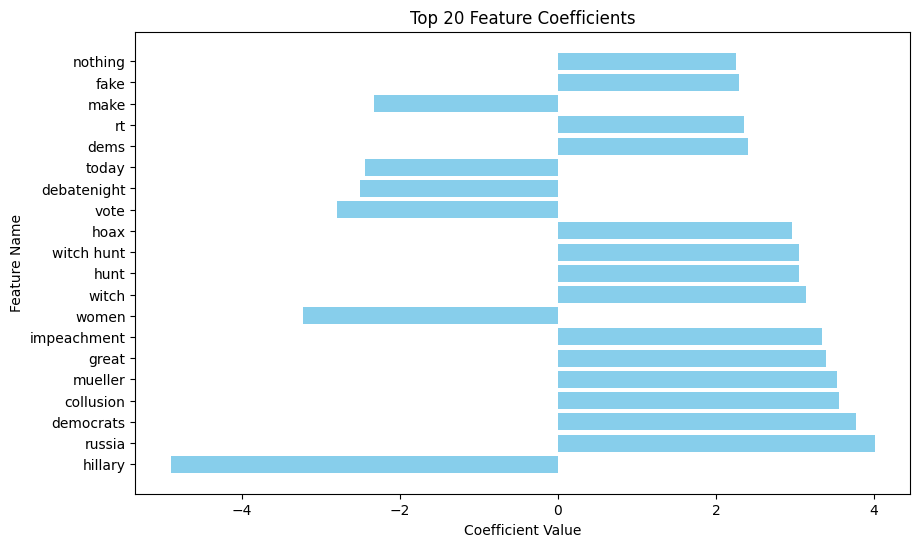

In [20]:
import matplotlib.pyplot as plt
import numpy as np


feature_names = np.array(count_vect.get_feature_names_out())
coef = log.coef_[0]

sorted_indices = np.argsort(np.abs(coef))[::-1]

# Select the top 20 indices
top_indices = sorted_indices[:20]

# Select corresponding feature names and coefficients
top_features = feature_names[top_indices]
top_coef = coef[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_coef, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Coefficients')
plt.show()


## Controlliamo la probabilità predetta di un tweet scelto a random di Hillary e Trump
---

Vedremo degli esempi sulle probabilità predette dal nostro algoritmo sia per Trump che per Hillary.

Il primo esempio consisterà nel valutare due tweet che non conosce. Successivamente useremo il nostro classificatore sul dataset.

In [21]:
estimator = LogisticRegression(solver='liblinear',penalty='l2',C=1.0)
estimator.fit(x_train,y_train_set)

# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!"
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = clean_tweet_nltk(source_test)

unknown_tweets_counts = count_vect.transform(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)
print(source_test)

display(pd.DataFrame(estimator.predict_proba(unknown_tweets_counts), columns=estimator.classes_))

['presidency ’ change — reveals . ’ seen need Donald Trump .', 'Crooked Hillary spending tremendous amounts Wall Street money false ads . dishonest person !']


,HillaryClinton,realDonaldTrump
0,0.999497,0.000503
1,0.109412,0.890588


In base al modello, la probabilità che il primo tweet sia di Hillary è del'99%, La probabilità che il secondo provenga da Trump è quasi del 80%. Il modello sembra funzionare

## Adesso proverò ad estrarre i tweet presenti nel dataset che hanno la probabilità predetta più alta e più bassa con autore Trump o Hillary in base al nostro modello.
---
**Lo farò in 4 passi:**
1. Usando il metodo Predict Proba per avere un array delle probabilità dei Tweet di Hillary e Trump
- Trasformare quest'array in un DataFrame
- Unire il Dataset con questo DataFrame
- Stampare il Tweet più probabile e il meno probabile di entrambi


In [22]:
Probas_x = pd.DataFrame(estimator.predict_proba(x_train), columns=estimator.classes_)


In [23]:
joined_x = pd.merge(dataset, Probas_x, left_index=True, right_index=True)

In [24]:
joined_x

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.064314,0.935686
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.135647,0.864353
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.665560,0.334440
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.079670,0.920330
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.232463,0.767537
...,...,...,...,...,...,...,...,...
3716,1216347531321446400,realDonaldTrump,20851,Congratulations to the Great State of Tennesse...,2020-02-21 18:10:54.088438,Sun Jan 12 13:13:44 +0000 2020,0.706277,0.293723
3717,309,realDonaldTrump,20857,Just got back only to hear of a last minute ch...,2020-02-22 01:07:58.785460,07-23-2019 23:32:21,0.205453,0.794547
3718,1210568154658803713,realDonaldTrump,20884,Speaker Pelosi and Chuck Schumer’s drive to tr...,2020-02-21 18:10:55.446675,Fri Dec 27 14:28:33 +0000 2019,0.993156,0.006844
3719,874284812193935360,HillaryClinton,20889,My heart is with the loved ones of the 49 peop...,2020-02-21 17:05:25.690788,Mon Jun 12 15:18:37 +0000 2017,0.822657,0.177343


**Dei tweet scritti da Hillary Clinton, il tweet più probabile e il meno probabile (secondo la predizione del nostro software) sono:**

In [25]:
joined_hillary = joined_x[joined_x['handle']=="HillaryClinton"]
for el in joined_hillary[joined_hillary['HillaryClinton']==max(joined_hillary['HillaryClinton'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(max(joined_hillary['HillaryClinton'])))

As we celebrate, let’s also remember the work ahead. Proud that groups that Onward Together supports—including @SwingLeft, which is laser-focused on taking back the House—have been making incredible progress in the fight for 2018 and beyond. Onward!
Probabilità: 0.99


In [26]:
for el in joined_hillary[joined_hillary['HillaryClinton']==min(joined_hillary['HillaryClinton'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(min(joined_hillary['HillaryClinton'])))

@KatieS @MoxxieVentures This is exciting, Katie. Congratulations—and love the name!
Probabilità: 0.01


**Dei tweet scritti da Donald Trump, il tweet più probabile e il meno probabile (secondo la predizione del nostro software) sono:**

In [27]:
joined_donald = joined_x[joined_x['handle']=="realDonaldTrump"]
for el in joined_donald[joined_donald['realDonaldTrump']==max(joined_donald['realDonaldTrump'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(max(joined_donald['realDonaldTrump'])))

....BUT MAYBE I STILL WILL. WITCH HUNT!
Probabilità: 0.99


In [28]:
for el in joined_donald[joined_donald['realDonaldTrump']==min(joined_donald['realDonaldTrump'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(min(joined_donald['realDonaldTrump'])))

Speaker Pelosi and Chuck Schumer’s drive to try and rig the trial against the President is misplaced. There is no factual basis for the Articles of Impeachment that passed the House. This President will be exonerated.” William McGinley  @foxandfriends
Probabilità: 0.01


# Classificare con più di 2 etichette
---

Provvederemo ora un classificatore (sempre basato su regressione logistica) che ci permetterà di classificare anche i tweet di una terza persona. Nel nostro caso sceglieremo i tweet di Barack Obama.

In [29]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'
obama = 'BarackObama'

In [30]:
# Creiamo il "triset"
pfc = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(pfc.format(hillary))
pfc = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(pfc.format(trump))
pfc = './Data/BarackObama.csv'
obama_df = pd.read_csv(pfc.format(obama))
triset = pd.concat([hillary_df,trump_df,obama_df], axis=0)
triset = triset.sort_values(by='retweet_count')
triset = triset.drop(columns=['Unnamed: 0'])
triset = triset.reset_index(drop=True)


Triset


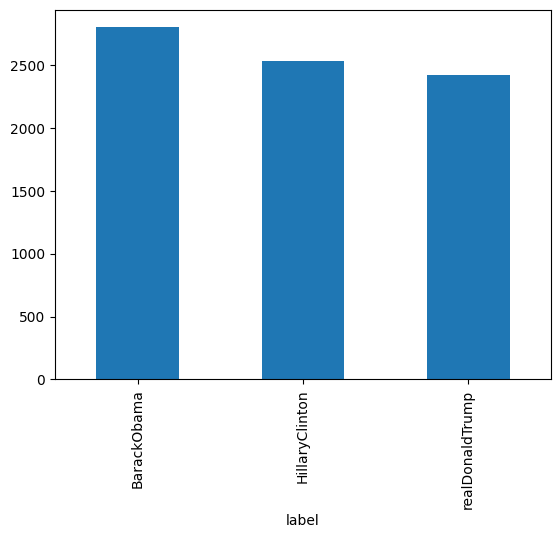

Training Set


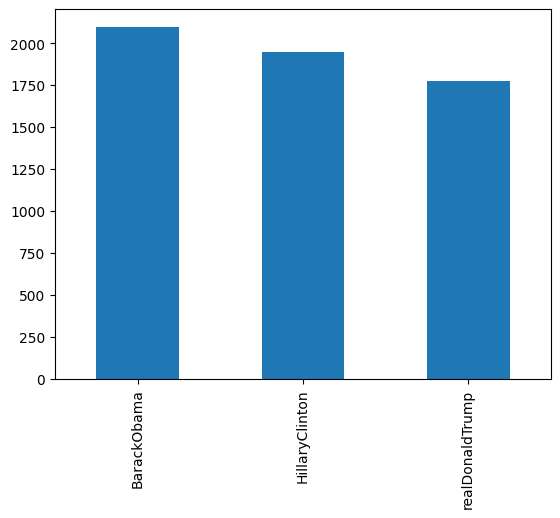

Test Set


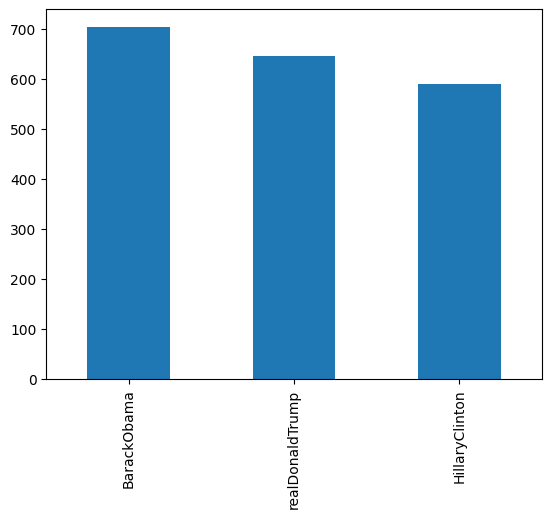

In [31]:
#Preprocessiamo i tweet
tweet_text = triset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = triset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro triset
from matplotlib import pyplot as plt
print("Triset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

print("Training Set")
pd.Series(y_train_set).value_counts().plot.bar()
plt.show()

print("Test Set")
pd.Series(y_test_set).value_counts().plot.bar()
plt.show()

## classificazione

Per poter classificare non potremo usare il metodo usato prima. Dovremo infatti usare delle tecniche più specifiche per gestire la presenza di più etichette. Nel nostro caso useremo la tecnica denominata **one vs all**. Possiamo raggiungere questo scopo indicando esplicitamente nell'istanziazione del Regressore Logistico il valore **ovr** al parametro **multi_class**.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(ngram_range=(1,4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer()
log = LogisticRegression(solver='liblinear', multi_class='ovr')

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)
    
x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

print(log.fit(x_train, y_train_set))

#Effettiamo il training e il test
y_train_preds = log.predict(x_train)
y_test_preds = log.predict(x_test)

#Stampiamo i valori dello score F1 per misurare le prestazioni
from sklearn.metrics import f1_score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'avra', 'avro', 'can', 'couldn', 'didn', 'doesn', 'don', 'fara', 'faro', 'giu', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'perche', 'pero', 'piu', 're', 'sara', 'saro', 'shan', 'shouldn', 'stara', 'staro', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


LogisticRegression(multi_class='ovr', solver='liblinear')
F1 training scores: 0.95
F1 test scores: 0.89


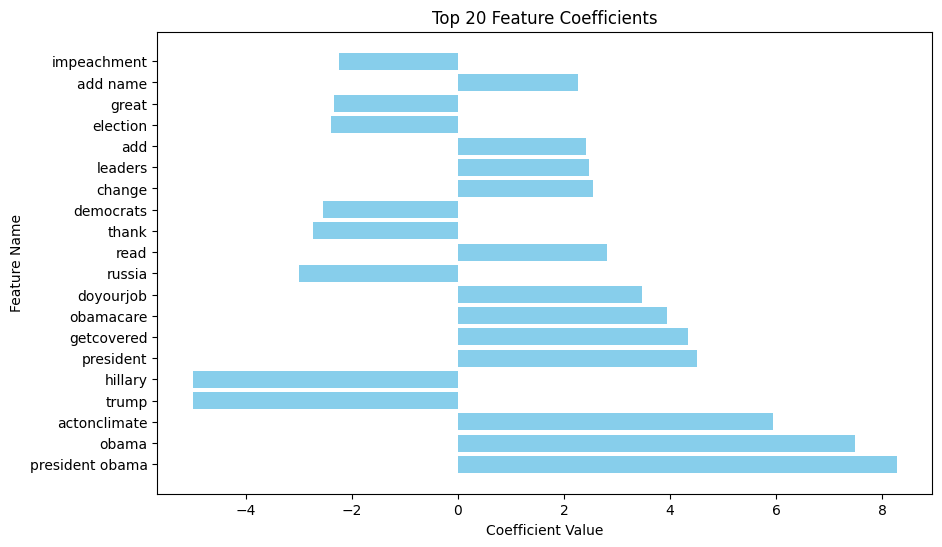

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming log is your logistic regression model
# Assuming count_vect is your CountVectorizer
feature_names = np.array(count_vect.get_feature_names_out())
coef = log.coef_[0]

# Sort indices based on the absolute values of coefficients
sorted_indices = np.argsort(np.abs(coef))[::-1]

# Select the top 20 indices
top_indices = sorted_indices[:20]

# Select corresponding feature names and coefficients
top_features = feature_names[top_indices]
top_coef = coef[top_indices]

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_coef, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Coefficients')
plt.show()


## Effettuiamo un test di predizione di tweet non conosciuti

In [34]:
estimator = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, multi_class='ovr')
estimator.fit(x_train,y_train_set)

# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
    "Here are a couple of articles that are worth reading — from housing to health, these stories use data to explore challenges we face and demonstrate how policy solutions along with civic engagement can make a real difference in people’s lives."
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = clean_tweet_nltk(source_test)

source_test = clean_tweet_nltk(source_test)

unknown_tweets_counts = count_vect.transform(source_test)

unknown_tweets = tfidf.transform(unknown_tweets_counts)

pd.DataFrame(log.predict_proba(unknown_tweets), columns=estimator.classes_)

,BarackObama,HillaryClinton,realDonaldTrump
0,0.121520,0.754292,0.124188
1,0.062807,0.248842,0.688351
2,0.358474,0.479676,0.161849


In [35]:
# Assuming log is your logistic regression model
# Assuming count_vect is your CountVectorizer
# Assuming source_test is a list of documents

for i, doc in enumerate(source_test[:3]):  # Displaying predictions for the first three documents
    # Transform the document using the CountVectorizer
    doc_vectorized = count_vect.transform([doc])

    # Get the model's prediction probability for each class
    probabilities = log.predict_proba(doc_vectorized)

    # Get the top 5 features that contributed most to the prediction for each class
    top_features_indices = np.argsort(-np.abs(log.coef_), axis=1)[:, :5]

    # Display the document
    print(f"Document {i + 1}: {doc}")

    for j, class_name in enumerate(log.classes_):
        # Display the class name
        print(f"\nClass: {class_name}")

        # Get the top contributing features and their coefficients for the current class
        top_feature_indices = top_features_indices[j]
        top_features = np.array(count_vect.get_feature_names_out())[top_feature_indices]
        top_coefs = log.coef_[j][top_feature_indices]

        # Display the top contributing features and their coefficients
        for feature, coef in zip(top_features, top_coefs):
            print(f"{feature}: {coef}")

        # Display the predicted probability and score for the current class
        predicted_probability = probabilities[0][j]
        predicted_score = log.decision_function(doc_vectorized)[0][j]

        print(f"Probability: {predicted_probability}")
        print(f"Score: {predicted_score}")

    print("\n")


Document 1: presidency ’ change — reveals . ’ seen need Donald Trump .

Class: BarackObama
president obama: 8.275839352563395
obama: 7.480047323736616
actonclimate: 5.935725299442697
trump: -5.002341374561005
hillary: -4.994740746914825
Probability: 0.0006659402179796795
Score: -7.312619455834598

Class: HillaryClinton
hillary: 6.9244879939162525
obama: -5.8789835953348
president obama: -5.694276315630932
trump: 4.484890551120938
actonclimate: -4.039151907357676
Probability: 0.9988858787580425
Score: 9.31134342361269

Class: realDonaldTrump
russia: 5.346697861318661
democrats: 4.603444941332177
president obama: -4.574003998573656
collusion: 4.423413580347989
mueller: 4.390301741204754
Probability: 0.0004481810239779995
Score: -7.708840241366387


Document 2: Crooked Hillary spending tremendous amounts Wall Street money false ads . dishonest person !

Class: BarackObama
president obama: 8.275839352563395
obama: 7.480047323736616
actonclimate: 5.935725299442697
trump: -5.002341374561005


## Ora controlliamo come si comporta sul triset

In [36]:
Probas_x = pd.DataFrame(estimator.predict_proba(x_train), columns=estimator.classes_)
joined_x = pd.merge(triset, Probas_x, left_index=True, right_index=True)

In [37]:
joined_x[joined_x['handle']=='BarackObama']

,tweet_id,handle,retweet_count,text,mined_at,created_at,BarackObama,HillaryClinton,realDonaldTrump
15,533307135006760961,BarackObama,163,"CHIP IN NOW: Get your impact doubled now, befo...",2020-02-26 16:11:21.320593,Fri Nov 14 17:15:04 +0000 2014,0.080066,0.593483,0.326451
16,663836262676234240,BarackObama,164,LIVE: President Obama is speaking to @OFA volu...,2020-02-26 16:11:16.656340,Mon Nov 09 21:51:13 +0000 2015,0.095348,0.761801,0.142851
19,654315653671727104,BarackObama,183,Read why @GovEdRendell thinks #TPP will be goo...,2020-02-26 16:11:16.938606,Wed Oct 14 15:19:43 +0000 2015,0.834137,0.122683,0.043180
22,663836997404991489,BarackObama,191,"""It's always good to be with OFA. It's a littl...",2020-02-26 16:11:16.656340,Mon Nov 09 21:54:08 +0000 2015,0.705536,0.187497,0.106967
23,532293470799417344,BarackObama,191,Watch: This is what you should know about @OFA...,2020-02-26 16:11:21.322595,Tue Nov 11 22:07:07 +0000 2014,0.119098,0.745474,0.135427
...,...,...,...,...,...,...,...,...,...
5689,741373595306360832,BarackObama,16477,"""Minds open. Hearts change. America shifts."" —...",2020-02-26 16:11:14.227129,Fri Jun 10 20:56:53 +0000 2016,0.449538,0.434506,0.115956
5742,723241770411122688,BarackObama,16778,"""'A strong spirit transcends rules,' Prince on...",2020-02-26 16:11:14.783644,Thu Apr 21 20:07:29 +0000 2016,0.295673,0.369182,0.335145
5776,1130546280286117890,BarackObama,17065,Here’s a great story: While we’ve still got a ...,2020-02-26 16:11:12.219311,Mon May 20 18:50:12 +0000 2019,0.061203,0.055866,0.882931
5794,1151621137979383808,BarackObama,17203,I have a good feeling about these Chicago @Urb...,2020-02-26 16:11:11.760884,Wed Jul 17 22:34:10 +0000 2019,0.105981,0.165546,0.728473


# Classificare usando KNN
---

Abbiamo visto come si comporta il nostro classificatore basato su regressione logistica. Ora proveremo ad usare un approccio differente utilizzando l'algoritmo KNN. Spiegheremo in breve cosa fare per utilizzarlo e come il programma lo utilizza.

---

Prima di tutto ricreiamo il dataset e suddividiamo i dati in training, validation e test set. Il validation set ci servirà per effettuare la ricerca degli iperparametri. Nel nostro caso K è un iperparametro e diremo successivamente come lo valuteremo.

Dataset


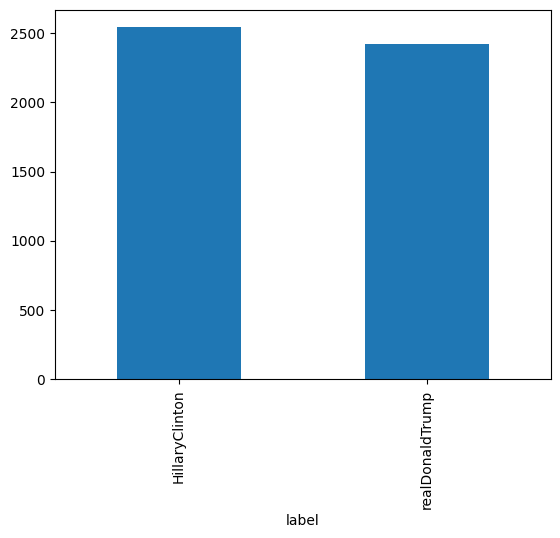

In [38]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

pfc = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(pfc.format(hillary))
pfc = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(pfc.format(trump))

dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

#Preprocessiamo i tweet
tweet_text = dataset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro dataset
from matplotlib import pyplot as plt
print("Dataset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)
#Del 75% userò il 33% per la validazione
train_set, vali_set, y_train_set, y_vali_set  = train_test_split(train_set,y_train_set, test_size=0.33)

## Esercitiamo il nostro classificatore
---

Dovremo inoltre indicare un valore K che massimizzi le misure di performance del nostro algoritmo. In particolare utilizzeremo un ciclo per trovare il valore K più performante misurando la performance del classificatore sul validation set.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

count_vect = CountVectorizer(ngram_range=(1,4), max_features=750, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer()

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)
    
x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

x_vali_counts = count_vect.transform(vali_set)
x_vali = tfidf.transform(x_vali_counts)

best_score = 0
best_k = 0
for k_value in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k_value)
    knn.fit(x_train, y_train_set)
    y_vali_preds = knn.predict(x_vali)
    print("{} - F1 Validation Score: {:0.2f}".format(k_value,f1_score(y_vali_set,y_vali_preds,average='weighted')))
    if f1_score(y_vali_set,y_vali_preds,average='weighted') > best_score:
        best_score = f1_score(y_vali_set,y_vali_preds,average='weighted')
        best_k = k_value

print("Il miglior K è {}.".format(best_k))
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train_set)

#Effettiamo il training e il test
y_train_preds = knn.predict(x_train)
y_test_preds = knn.predict(x_test)

#Calcoliamo lo score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'avra', 'avro', 'can', 'couldn', 'didn', 'doesn', 'don', 'fara', 'faro', 'giu', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'perche', 'pero', 'piu', 're', 'sara', 'saro', 'shan', 'shouldn', 'stara', 'staro', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


1 - F1 Validation Score: 0.61
2 - F1 Validation Score: 0.61
3 - F1 Validation Score: 0.51
4 - F1 Validation Score: 0.59
5 - F1 Validation Score: 0.51
6 - F1 Validation Score: 0.53
7 - F1 Validation Score: 0.46
8 - F1 Validation Score: 0.48
9 - F1 Validation Score: 0.44
10 - F1 Validation Score: 0.45
Il miglior K è 2.
F1 training scores: 0.97
F1 test scores: 0.63


In [40]:
# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = clean_tweet_nltk(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)

pd.DataFrame(knn.predict_proba(unknown_tweets), columns=knn.classes_)

,HillaryClinton,realDonaldTrump
0,1.0,0.0
1,0.0,1.0


In [41]:
Probas_x = pd.DataFrame(knn.predict_proba(x_train), columns=knn.classes_)
joined_x = pd.merge(dataset, Probas_x, left_index=True, right_index=True)

In [42]:
joined_x

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.0,1.0
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.5,0.5
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.0,1.0
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.0,1.0
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.0,1.0
...,...,...,...,...,...,...,...,...
2488,22,realDonaldTrump,11413,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-22 01:07:58.785460,02-09-2020 00:07:31,0.0,1.0
2489,1226296531113955331,realDonaldTrump,11414,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-21 18:10:49.166956,Sun Feb 09 00:07:31 +0000 2020,0.0,1.0
2490,1219430494460268544,realDonaldTrump,11414,Texas Rep Roger Williams (@RepRWilliams) has d...,2020-02-21 18:10:52.524014,Tue Jan 21 01:24:20 +0000 2020,0.0,1.0
2491,1198688960207298562,realDonaldTrump,11436,Witch Hunt! https://t.co/CvZtyHMsGo,2020-02-21 18:10:59.093486,Sun Nov 24 19:44:53 +0000 2019,0.0,1.0


In [43]:
joined_x[joined_x['handle']=='realDonaldTrump']

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.0,1.0
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.0,1.0
6,1068,realDonaldTrump,41,I hear by demand a second investigation after ...,2020-02-22 01:07:58.785460,03-03-2017 20:47:30,0.0,1.0
142,85,realDonaldTrump,554,....What right does Crazy Nancy have to hold u...,2020-02-22 01:07:58.785460,12-23-2019 22:09:32,1.0,0.0
314,804,realDonaldTrump,809,“Trump recognized Russian Meddling MANY TIMES....,2020-02-22 01:07:58.785460,07-19-2018 13:27:03,0.5,0.5
...,...,...,...,...,...,...,...,...
2488,22,realDonaldTrump,11413,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-22 01:07:58.785460,02-09-2020 00:07:31,0.0,1.0
2489,1226296531113955331,realDonaldTrump,11414,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-21 18:10:49.166956,Sun Feb 09 00:07:31 +0000 2020,0.0,1.0
2490,1219430494460268544,realDonaldTrump,11414,Texas Rep Roger Williams (@RepRWilliams) has d...,2020-02-21 18:10:52.524014,Tue Jan 21 01:24:20 +0000 2020,0.0,1.0
2491,1198688960207298562,realDonaldTrump,11436,Witch Hunt! https://t.co/CvZtyHMsGo,2020-02-21 18:10:59.093486,Sun Nov 24 19:44:53 +0000 2019,0.0,1.0


In [44]:
joined_x[joined_x['handle']=='HillaryClinton']

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.5,0.5
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.0,1.0
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.0,1.0
5,1209550097152913409,HillaryClinton,17,"@KatieS @MoxxieVentures This is exciting, Kati...",2020-02-21 17:05:22.423803,Tue Dec 24 19:03:10 +0000 2019,0.5,0.5
7,1029367764354576384,HillaryClinton,68,@itsmebeccam @TATLGDoc I’m so proud of you Reb...,2020-02-21 17:05:24.849021,Tue Aug 14 14:02:54 +0000 2018,1.0,0.0
...,...,...,...,...,...,...,...,...
2462,781869512983515136,HillaryClinton,11144,What kind of man stays up all night to smear a...,2020-02-21 17:05:27.922820,Fri Sep 30 14:53:12 +0000 2016,0.5,0.5
2466,1209519768748929024,HillaryClinton,11165,"A merry Christmas to all, and to all a good ni...",2020-02-21 17:05:22.423803,Tue Dec 24 17:02:39 +0000 2019,0.5,0.5
2467,859386649125548032,HillaryClinton,11194,Watch &amp; prepare to tear up. Thanks @jimmyk...,2020-02-21 17:05:25.690788,Tue May 02 12:38:38 +0000 2017,0.5,0.5
2468,796143289971994624,HillaryClinton,11229,"Remember, if you are in line before polls clos...",2020-02-21 17:05:25.690788,Wed Nov 09 00:12:06 +0000 2016,1.0,0.0


# MultinomialNB
---

Dataset


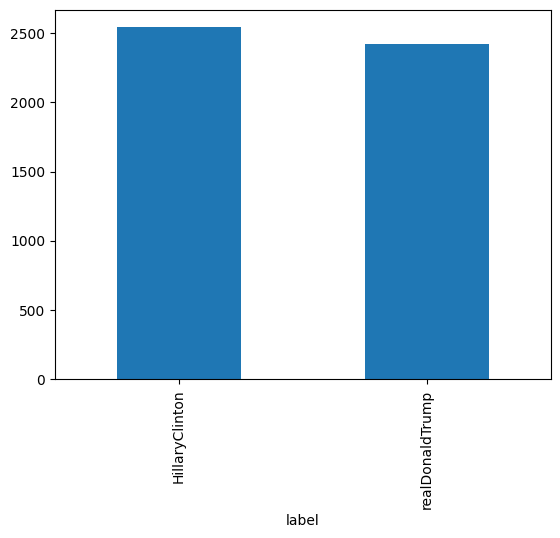

In [45]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

pfc = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(pfc.format(hillary))
pfc = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(pfc.format(trump))
dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)


#Preprocessiamo i tweet
tweet_text = dataset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro dataset
from matplotlib import pyplot as plt
print("Dataset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

count_vect = CountVectorizer(ngram_range=(1,4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer()

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)
    
x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

nb = MultinomialNB()
nb.fit(x_train, y_train_set)

#Effettiamo il training e il test
y_train_preds = nb.predict(x_train)
y_test_preds = nb.predict(x_test)

#Calcoliamo lo score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'avra', 'avro', 'can', 'couldn', 'didn', 'doesn', 'don', 'fara', 'faro', 'giu', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'perche', 'pero', 'piu', 're', 'sara', 'saro', 'shan', 'shouldn', 'stara', 'staro', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


F1 training scores: 0.95
F1 test scores: 0.92


In [47]:
#1 hillary
#2 trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
]



source_test = clean_tweet_nltk(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)

pd.DataFrame(nb.predict_proba(unknown_tweets), columns=nb.classes_)

,HillaryClinton,realDonaldTrump
0,0.898485,0.101515
1,0.052069,0.947931


In [48]:
Probas_x = pd.DataFrame(nb.predict_proba(x_train), columns=nb.classes_)
joined_x = pd.merge(dataset, Probas_x, left_index=True, right_index=True)

In [49]:
joined_x

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.010451,0.989549
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.030193,0.969807
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.588560,0.411440
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.008453,0.991547
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.095255,0.904745
...,...,...,...,...,...,...,...,...
3716,1216347531321446400,realDonaldTrump,20851,Congratulations to the Great State of Tennesse...,2020-02-21 18:10:54.088438,Sun Jan 12 13:13:44 +0000 2020,0.877896,0.122104
3717,309,realDonaldTrump,20857,Just got back only to hear of a last minute ch...,2020-02-22 01:07:58.785460,07-23-2019 23:32:21,0.057184,0.942816
3718,1210568154658803713,realDonaldTrump,20884,Speaker Pelosi and Chuck Schumer’s drive to tr...,2020-02-21 18:10:55.446675,Fri Dec 27 14:28:33 +0000 2019,0.846726,0.153274
3719,874284812193935360,HillaryClinton,20889,My heart is with the loved ones of the 49 peop...,2020-02-21 17:05:25.690788,Mon Jun 12 15:18:37 +0000 2017,0.920202,0.079798


## RANDOM FOREST

Dataset


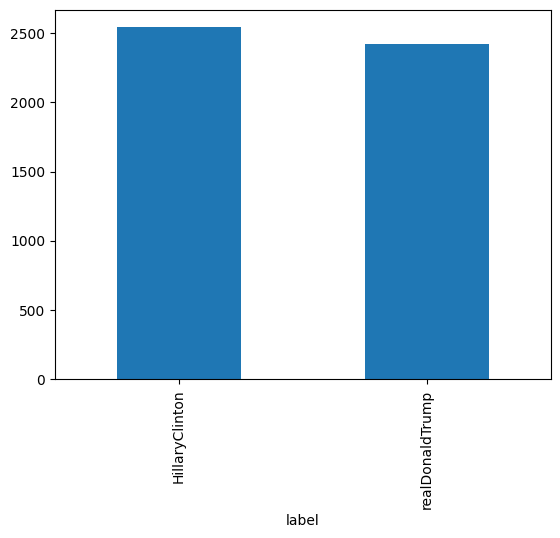

In [50]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

pfc = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(pfc.format(hillary))
pfc = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(pfc.format(trump))
dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)


#Preprocessiamo i tweet
tweet_text = dataset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro dataset
from matplotlib import pyplot as plt
print("Dataset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

# Creiamo le matrici TF-IDF per il training set e il test set
count_vect = CountVectorizer(ngram_range=(1, 4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf_transformer = TfidfTransformer()

x_train_counts = count_vect.fit_transform(train_set)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(test_set)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

# Addestramento e valutazione del classificatore Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_tfidf, y_train_set)

y_train_preds_rf = rf.predict(x_train_tfidf)
y_test_preds_rf = rf.predict(x_test_tfidf)

print("F1 training scores (Random Forest): {:0.2f}".format(f1_score(y_train_set, y_train_preds_rf, average='weighted')))
print("F1 test scores (Random Forest): {:0.2f}".format(f1_score(y_test_set, y_test_preds_rf, average='weighted')))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'avra', 'avro', 'can', 'couldn', 'didn', 'doesn', 'don', 'fara', 'faro', 'giu', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'perche', 'pero', 'piu', 're', 'sara', 'saro', 'shan', 'shouldn', 'stara', 'staro', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


F1 training scores (Random Forest): 1.00
F1 test scores (Random Forest): 0.89


In [59]:
#1 hillary
#2 trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
]



source_test = clean_tweet_nltk(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)

predictions_rf = rf.predict(unknown_tweets)

probabilities_rf = rf.predict_proba(unknown_tweets)

result_rf = pd.DataFrame(probabilities_rf, columns=rf.classes_)

result_rf

,HillaryClinton,realDonaldTrump
0,0.930000,0.070000
1,0.302796,0.697204


In [60]:
probas_x_rf = rf.predict_proba(x_train_tfidf)

probas_x_df_rf = pd.DataFrame(probas_x_rf, columns=rf.classes_)

joined_x_rf = pd.merge(dataset, probas_x_df_rf, left_index=True, right_index=True)

joined_x_rf

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.000000,1.000000
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.030000,0.970000
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.932917,0.067083
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.000000,1.000000
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.031687,0.968313
...,...,...,...,...,...,...,...,...
3716,1216347531321446400,realDonaldTrump,20851,Congratulations to the Great State of Tennesse...,2020-02-21 18:10:54.088438,Sun Jan 12 13:13:44 +0000 2020,0.931364,0.068636
3717,309,realDonaldTrump,20857,Just got back only to hear of a last minute ch...,2020-02-22 01:07:58.785460,07-23-2019 23:32:21,0.000000,1.000000
3718,1210568154658803713,realDonaldTrump,20884,Speaker Pelosi and Chuck Schumer’s drive to tr...,2020-02-21 18:10:55.446675,Fri Dec 27 14:28:33 +0000 2019,0.991383,0.008617
3719,874284812193935360,HillaryClinton,20889,My heart is with the loved ones of the 49 peop...,2020-02-21 17:05:25.690788,Mon Jun 12 15:18:37 +0000 2017,0.990000,0.010000


# Confronto delle prestazioni
---
Valutiamo prima di tutto l'operato dei classificatori usando due etichette.

In [43]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

pfc = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(pfc.format(hillary))
pfc = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(pfc.format(trump))

dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

tweet_text = dataset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

from sklearn.model_selection import train_test_split

np.random.seed(1234)
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

scores = pd.DataFrame(['Classificatore', 'F1'])

## Regressore Logistico

In [44]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

# Inizializzazione del DataFrame
scores = pd.DataFrame(columns=['Classificatore', 'F1_train', 'F1_test'])

list_stop_words = []  # Assicurati di inizializzare correttamente la tua lista di stop words

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1, 4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    log = LogisticRegression(solver='liblinear')   

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)
    
    log.fit(x_train, y_train_set)

    y_train_preds = log.predict(x_train)
    y_test_preds = log.predict(x_test)

    # Calcolo del nuovo punteggio per il training set
    new_train_score = f1_score(y_train_set, y_train_preds, average='weighted')

    # Calcolo del nuovo punteggio per il test set
    new_test_score = f1_score(y_test_set, y_test_preds, average='weighted')

    scores.loc[len(scores)] = ['LOG_REG features:{}'.format(750*2**i), new_train_score, new_test_score]




## KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    knn = KNeighborsClassifier(n_neighbors=3)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    knn.fit(x_train, y_train_set)

    y_train_preds = knn.predict(x_train)
    y_test_preds = knn.predict(x_test)

    """
    print("#features: {} - k = 3\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    
    new_train_score = f1_score(y_train_set, y_train_preds, average='weighted')

    new_test_score = f1_score(y_test_set, y_test_preds, average='weighted')

    # Aggiunta dei risultati al DataFrame
    scores.loc[len(scores)] = ['KNN TR features:{}'.format(750*2**i), new_train_score, new_test_score]


## Multinomial Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    nb = MultinomialNB()
    nb.fit(x_train, y_train_set)

    y_train_preds = nb.predict(x_train)
    y_test_preds = nb.predict(x_test)
    
    """
    print("#features: {}\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_train_score = f1_score(y_train_set, y_train_preds, average='weighted')

    new_test_score = f1_score(y_test_set, y_test_preds, average='weighted')

    # Aggiunta dei risultati al DataFrame
    scores.loc[len(scores)] = ['MNB TE features:{}'.format(750*2**i), new_train_score, new_test_score]
    
    

## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1, 4), max_features=750 * 2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(x_train, y_train_set)

    y_train_preds_rf = rf_classifier.predict(x_train)
    y_test_preds_rf = rf_classifier.predict(x_test)

    new_train_score_rf = f1_score(y_train_set, y_train_preds_rf, average='weighted')
    new_test_score_rf = f1_score(y_test_set, y_test_preds_rf, average='weighted')

    scores.loc[len(scores)] = [f'Random Forest TE features:{750 * 2**i}', new_train_score_rf, new_test_score_rf]


In [48]:
scores

,Classificatore,F1_train,F1_test
0,LOG_REG features:750,0.923019,0.895728
1,LOG_REG features:1500,0.931905,0.904629
2,LOG_REG features:3000,0.941870,0.907025
3,KNN TR features:750,0.697643,0.569684
4,KNN TR features:1500,0.615990,0.467866
5,KNN TR features:3000,0.550185,0.408776
6,MNB TE features:750,0.899489,0.887412
7,MNB TE features:1500,0.915150,0.902814
8,MNB TE features:3000,0.931072,0.909421
9,Random Forest TE features:750,0.990594,0.885625


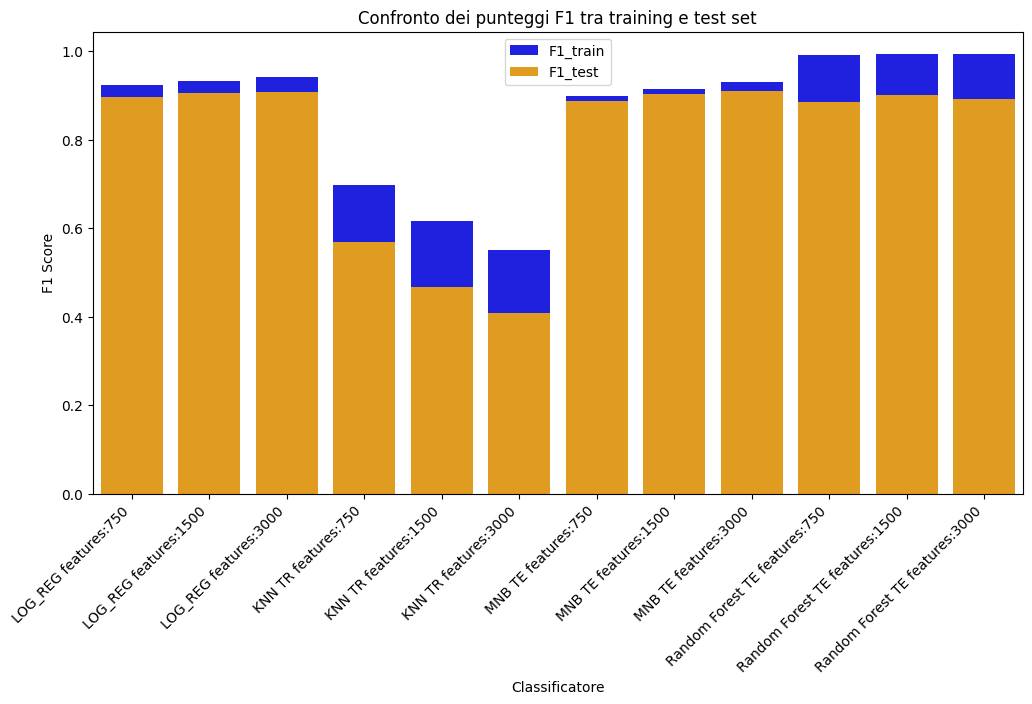

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creazione del grafico
plt.figure(figsize=(12, 6))
sns.barplot(x='Classificatore', y='F1_train', data=scores, color='blue', label='F1_train')
sns.barplot(x='Classificatore', y='F1_test', data=scores, color='orange', label='F1_test')
plt.title('Confronto dei punteggi F1 tra training e test set')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

**Come possiamo notare** il random forest, la regressione logistica e il classificatore multinomiale lavorano meglio all'aumentare del numero delle feature. KNN invece peggiora questo è derivato dal fatto che, aumentando la dimensionalità delle rappresentazioni, KNN ha prestazioni peggiori (https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction).

---

Facciamo un ultimo confronto valutando il comportamento dei classificatori (con gli stessi settaggi) su dataset con **3 etichette**.

In [50]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'
obama = 'BarackObama'

# Creiamo il "triset"
pfc = './Data/HillaryClinton.csv'
hillary_df = pd.read_csv(pfc.format(hillary))
pfc = './Data/realDonaldTrump.csv'
trump_df = pd.read_csv(pfc.format(trump))
pfc = './Data/BarackObama.csv'
obama_df = pd.read_csv(pfc.format(obama))
triset = pd.concat([hillary_df,trump_df,obama_df], axis=0)
triset = triset.sort_values(by='retweet_count')
triset = triset.drop(columns=['Unnamed: 0'])
triset = triset.reset_index(drop=True)

tweet_text = triset['text'].values
clean_text = clean_tweet_nltk(tweet_text)

clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = triset['handle'].map(lambda x: 0 if x == 'HillaryClinton' else 1 if x == 'realDonaldTrump' else 2).values

from sklearn.model_selection import train_test_split

np.random.seed(1234)
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

scores = pd.DataFrame(['Classificatore', 'F1'])
# Stampa del DataFrame risultante
print(scores)

                0
0  Classificatore
1              F1


## Regressore Logistico

In [51]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

# Inizializzazione del DataFrame
scores = pd.DataFrame(columns=['Classificatore', 'F1_train', 'F1_test'])

list_stop_words = []  # Assicurati di inizializzare correttamente la tua lista di stop words

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1, 4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    log = LogisticRegression(solver='liblinear')   

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)
    
    log.fit(x_train, y_train_set)

    y_train_preds = log.predict(x_train)
    y_test_preds = log.predict(x_test)

    # Calcolo del nuovo punteggio per il training set
    new_train_score = f1_score(y_train_set, y_train_preds, average='weighted')

    # Calcolo del nuovo punteggio per il test set
    new_test_score = f1_score(y_test_set, y_test_preds, average='weighted')

    # Aggiunta dei risultati al DataFrame
    scores.loc[len(scores)] = ['LOG_REG features:{}'.format(750*2**i), new_train_score, new_test_score]

# Stampa del DataFrame risultante
print(scores)

          Classificatore  F1_train   F1_test
0   LOG_REG features:750  0.893540  0.857685
1  LOG_REG features:1500  0.917551  0.870132
2  LOG_REG features:3000  0.933328  0.880915


## KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    knn = KNeighborsClassifier(n_neighbors=3)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    knn.fit(x_train, y_train_set)

    y_train_preds = knn.predict(x_train)
    y_test_preds = knn.predict(x_test)

    """
    print("#features: {} - k = 3\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    
    new_train_score = f1_score(y_train_set, y_train_preds, average='weighted')

    new_test_score = f1_score(y_test_set, y_test_preds, average='weighted')

    # Aggiunta dei risultati al DataFrame
    scores.loc[len(scores)] = ['KNN TR features:{}'.format(750*2**i), new_train_score, new_test_score]

# Stampa del DataFrame risultante
print(scores)

          Classificatore  F1_train   F1_test
0   LOG_REG features:750  0.893540  0.857685
1  LOG_REG features:1500  0.917551  0.870132
2  LOG_REG features:3000  0.933328  0.880915
3    KNN TR features:750  0.733048  0.616201
4   KNN TR features:1500  0.647568  0.540196
5   KNN TR features:3000  0.586410  0.475256


## Multinomial Naive Bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    nb = MultinomialNB()
    nb.fit(x_train, y_train_set)

    y_train_preds = nb.predict(x_train)
    y_test_preds = nb.predict(x_test)
    
    """
    print("#features: {}\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_train_score = f1_score(y_train_set, y_train_preds, average='weighted')

    new_test_score = f1_score(y_test_set, y_test_preds, average='weighted')

    # Aggiunta dei risultati al DataFrame
    scores.loc[len(scores)] = ['MNB TE features:{}'.format(750*2**i), new_train_score, new_test_score]

# Stampa del DataFrame risultante
print(scores)

          Classificatore  F1_train   F1_test
0   LOG_REG features:750  0.893540  0.857685
1  LOG_REG features:1500  0.917551  0.870132
2  LOG_REG features:3000  0.933328  0.880915
3    KNN TR features:750  0.733048  0.616201
4   KNN TR features:1500  0.647568  0.540196
5   KNN TR features:3000  0.586410  0.475256
6    MNB TE features:750  0.859836  0.849084
7   MNB TE features:1500  0.886294  0.862967
8   MNB TE features:3000  0.904488  0.872807


## Random forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1, 4), max_features=750 * 2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(x_train, y_train_set)

    y_train_preds_rf = rf_classifier.predict(x_train)
    y_test_preds_rf = rf_classifier.predict(x_test)

    new_train_score_rf = f1_score(y_train_set, y_train_preds_rf, average='weighted')
    new_test_score_rf = f1_score(y_test_set, y_test_preds_rf, average='weighted')

    scores.loc[len(scores)] = [f'Random Forest TE features:{750 * 2**i}', new_train_score_rf, new_test_score_rf]

# Stampa del DataFrame risultante
print(scores)

                    Classificatore  F1_train   F1_test
0             LOG_REG features:750  0.893540  0.857685
1            LOG_REG features:1500  0.917551  0.870132
2            LOG_REG features:3000  0.933328  0.880915
3              KNN TR features:750  0.733048  0.616201
4             KNN TR features:1500  0.647568  0.540196
5             KNN TR features:3000  0.586410  0.475256
6              MNB TE features:750  0.859836  0.849084
7             MNB TE features:1500  0.886294  0.862967
8             MNB TE features:3000  0.904488  0.872807
9    Random Forest TE features:750  0.989879  0.857173
10  Random Forest TE features:1500  0.994335  0.863393
11  Random Forest TE features:3000  0.995879  0.869377


In [56]:
scores

,Classificatore,F1_train,F1_test
0,LOG_REG features:750,0.893540,0.857685
1,LOG_REG features:1500,0.917551,0.870132
2,LOG_REG features:3000,0.933328,0.880915
3,KNN TR features:750,0.733048,0.616201
4,KNN TR features:1500,0.647568,0.540196
5,KNN TR features:3000,0.586410,0.475256
6,MNB TE features:750,0.859836,0.849084
7,MNB TE features:1500,0.886294,0.862967
8,MNB TE features:3000,0.904488,0.872807
9,Random Forest TE features:750,0.989879,0.857173


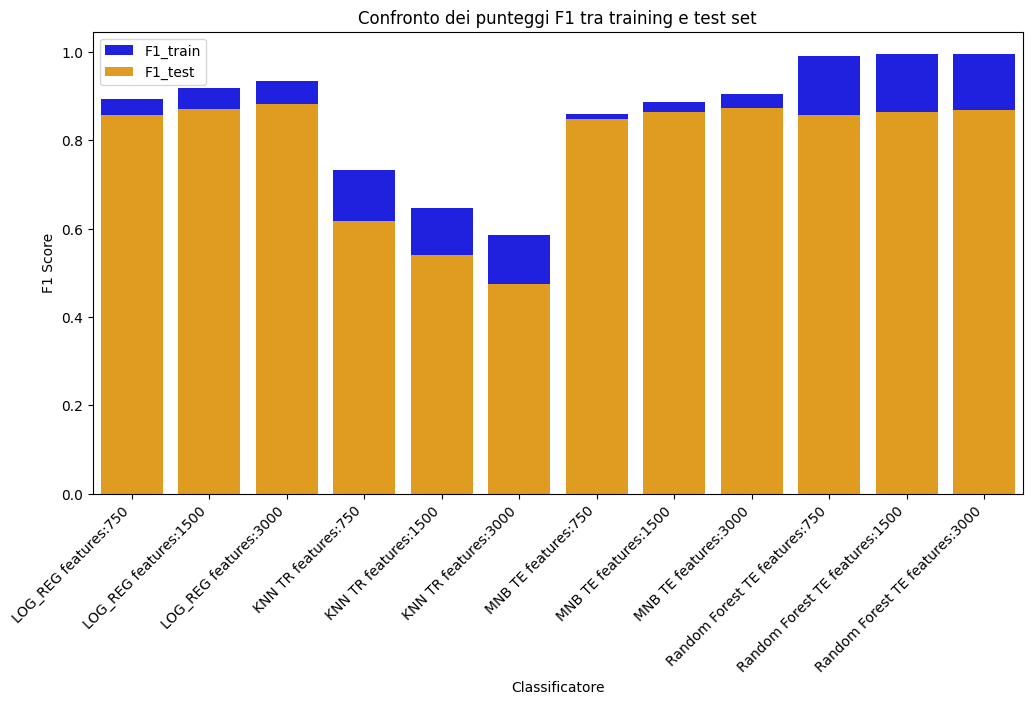

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Classificatore', y='F1_train', data=scores, color='blue', label='F1_train')
sns.barplot(x='Classificatore', y='F1_test', data=scores, color='orange', label='F1_test')
plt.title('Confronto dei punteggi F1 tra training e test set')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Non ci sorprende notare che le prestazioni sono generalmente calate per tutti gli algoritmi, in quanto questo dipende dal fatto che abbiamo aggiunto una nuova etichetta: ciò ha inserito maggiore incertezza.


In [58]:
def classify(clas, tfidf, vect, dataset):
    while True:
        dt = None
        print("\n\nSCEGLI COME PREFERISCI FORNIRE IL TWEET DA CLASSIFICARE")
        print("1) Inserimento Manuale")
        print("2) Tweet presente all'interno al Dataframe")
        print("3) Ritornare al menù principale")
        print("[Default: 3]")
        answer = input("La tua scelta: ")
        
        if answer == '1':
            dt = manualTweets()

        elif answer == '3':
            return
        else:
            dt = datasetTweets(dataset)
        
        clean_tweets = clean_tweet_nltk(dt['text'].tolist())
        count_tweets = vect.transform(clean_tweets)
        tf_tweets = tfidf.transform(count_tweets)
        
        Probas_x = pd.DataFrame(clas.predict_proba(tf_tweets), columns = clas.classes_)
        joined_x = dt
        joined_x[clas.classes_] = Probas_x
        joined_x = joined_x.reset_index(drop=True)
        display(joined_x)
        
        for x in dt['text'].tolist():
            display(eli5.show_prediction(clas, doc=x, vec=vect, top=40,target_names=clas.classes_))
        

def manualTweets():
    tweets = []
    
    print("Quanti tweet vuoi inserire?\n[Max 10, Default 1]\n")
    answer = input("La tua scelta: ")
    if answer.isdigit():
        if int(answer) > 10 or int(answer) < 1:
            answer = 1
        else:
            answer = int(answer)
    else:
        answer = 1
    
    for a in range(answer):
        print("\nScrivi un tweet:")
        tweet = input("Il tuo tweet: ")
        tweets.append(tweet)
        
    dt = pd.DataFrame()
    dt['text'] = tweets
    dt['handle'] = "you"
    
    return dt    


def datasetTweets(dataset):
    tweets = []
    handles = []
    
    print("Quanti tweet vuoi prelevare dal dataset?\n[Max 10, Default 1]")
    answer = input("La tua scelta: ")
    if answer.isdigit():
        if int(answer) > 10 or int(answer) < 1:
            answer = 1
        else:
            answer = int(answer)
    else:
        answer = 1
    
    for a in range(answer):
        print("\nScrivi il numero della riga del dataset da cui prendere il tweet\n[Max {}, Default 0]:".format(len(dataset)-1))
        answer = input("La tua scelta: ")
        if answer.isdigit():
            if int(answer) > (len(dataset)-1) or int(answer) < 0:
                answer = 0
            else:
                answer = int(answer)
        else:
            answer = 0
        tweets.append(dataset.at[answer, 'text'])
        handles.append(dataset.at[answer, 'handle'])
        print("Prelevato il tweet #{} di {}!\n".format(answer, dataset.at[answer, 'handle']))   
        
    dt = pd.DataFrame()
    dt['text'] = tweets
    dt['handle'] = handles
    
    return dt

In [59]:
def checkLenTweet(raw_data):
    data = txt.replace_urls(raw_data,"")
    data = txt.replace_emails(data,"")
    data = txt.replace_emojis(data,"")
    data = txt.replace_user_handles(data,"")
    data = txt.replace_phone_numbers(data,"")
    data = txt.replace_numbers(data,"")
    data = txt.replace_currency_symbols(data,"")
    data = txt.replace_hashtags(data,"")
    if len(data) < 28:
        return False
    else:
        return True

def clean_tweet_nltk(raw_data):
    tknzr = TweetTokenizer()
    stop_words = set(stopwords.words('english'))

    cleaned_data = []

    for tweet in raw_data:
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Remove user handles
        tweet = re.sub(r'@[^\s]+', '', tweet)
        # Tokenize the tweet
        tokens = tknzr.tokenize(tweet)
        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in stop_words]
        # Join the tokens back into a string
        cleaned_tweet = ' '.join(tokens)
        cleaned_data.append(cleaned_tweet)

    return cleaned_data

#Crea la cartella da cui cercare i tweet
def makeData():
    import os
    print("\n\nCONTROLLO SE ESISTE LA CARTELLA DATA")
    try:
        pfc = './Data'
        os.mkdir(pfc)
        print("Cartella creata.")
    except:
        print("Cartella esistente.")

In [60]:
#Stampa la lista dei dataframe salvati in memoria
def printDF():
    import os
    pfc = './Data'
    fileList = os.listdir(pfc)
    try:
        fileList =  [re.search('[A-Za-z]*[^.csv]', x).group(0) if x != '.csv' else '' for x in fileList]
    except Exception as e:
        print(e)
    print(fileList)

#Restituisce la lista dei dataframe salvati in memoria
def getDF():
    import os
    pfc = './Data'
    fileList = os.listdir(pfc)
    try:
        fileList =  [re.search('[A-Za-z]*[^.csv]', x).group(0) if x != '.csv' else '' for x in fileList]
    except Exception as e:
        print(e)
    return(fileList)

#Aggiunge un utente (se esiste) nel Dataset
def addUser(username,dataset):
    try:
        user_df = pd.read_csv('./Data/{}.csv'.format(username))
        dataset = pd.concat([dataset, user_df], axis=0, sort=True)
        dataset = dataset.sort_values(by='retweet_count')
        dataset = dataset.drop(columns=['Unnamed: 0'])
        dataset = dataset.reset_index(drop=True)
        print("Aggiunto l'utente {}!".format(username))
    except Exception as e:
        print("Errore nell'aggiunta dell'utente!")
        print(e)
        return dataset, 1
    return dataset, 0

#Rimuove un utente (se presente) dal Dataset
def dropUser(username,dataset):
    print("Rimosso l'utente {}!".format(username))
    dt = dataset[dataset['handle'] != username]
    dt = dt.reset_index(drop=True)
    return dt

#Mostra una sezione del Dataset
def printDataset(dataset, low_lim = 0, high_lim = 0, user = None):
    if high_lim <= low_lim:
        high_lim = len(dataset)-1        
    if user == None:
        display(dataset[low_lim:high_lim])
    else:
        display(dataset[dataset['handle'] == user])
        
        


In [61]:
#Stampa i plot dei dati
def printPlot(dataset,s=''):
    print(s)
    ans = input("Stampare il plot dei dati? [s,n] Default n. ")
    if ans == 's':
        pd.Series(dataset).value_counts().plot.bar()
        plt.show()

#Applica preprocessing sul dataset
def clean(dataset):
    tweet_text = dataset['text'].values
    clean_text = clean_tweet_nltk(tweet_text)
    clean_df = pd.DataFrame(clean_text, columns=['x'])
    clean_df['label'] = dataset['handle'].values
    
    printPlot(clean_df['label'].tolist(),"Dataset")
    
    return clean_df

#Divide il dataset in TrS, TeS ed eventualmente VaS
def splitDataset(dataset,percent=0.25,knn=False,knn_percent=0.33):

    train_set, test_set, y_train_set, y_test_set  = train_test_split(dataset['x'].tolist(),dataset['label'].tolist(), test_size=percent)
    
    printPlot(y_train_set,'Training Set')
    
    if knn:
        train_set, vali_set, y_train_set, y_vali_set  = train_test_split(train_set,y_train_set, test_size=knn_percent)
        printPlot(y_vali_set,'Validation Set')
            
    printPlot(y_test_set,'Test Set')
    
    if knn:
        return train_set, y_train_set, test_set, y_test_set, vali_set, y_vali_set
    else:
        return train_set, y_train_set, test_set, y_test_set

#Regressore Logistico
def LRegr(dataset, num_label, features=20000, tdf=True):
    
    train_set, y_train_set, test_set, y_test_set = splitDataset(dataset)
    
    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=tdf)

    
    if num_label > 2:
        log = LogisticRegression(solver='liblinear', multi_class='ovr')
    else:
        log = LogisticRegression(solver='liblinear')
        
    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)
    
    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    log.fit(x_train, y_train_set)

    y_train_preds = log.predict(x_train)
    y_test_preds = log.predict(x_test)

    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    
    return log, tfidf, count_vect

#KNN
def KNN(dataset, features=750, tdf=True, k=0):
    
    train_set, y_train_set, test_set, y_test_set, vali_set, y_vali_set = splitDataset(dataset, knn = True)
    
    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=tdf)
    
    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)
    
    x_vali_counts = count_vect.transform(vali_set)
    x_vali = tfidf.transform(x_vali_counts)
    
    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)
      
    
    if k == 0:
        print("Valuteremo ora che K assegnare per massimizzare le performances.")
        best_score = 0
        best_k = 0

        for k_value in range(1,11):
            knn = KNeighborsClassifier(n_neighbors=k_value)
            knn.fit(x_train, y_train_set)
            y_vali_preds = knn.predict(x_vali)
            print("{} - F1 Validation Score: {:0.2f}".format(k_value,f1_score(y_vali_set,y_vali_preds,average='weighted')))
            if f1_score(y_vali_set,y_vali_preds,average='weighted') > best_score:
                best_score = f1_score(y_vali_set,y_vali_preds,average='weighted')
                best_k = k_value

        print("Il miglior K è {}.".format(best_k))
    else:
        k_value = k
        
    knn = KNeighborsClassifier(n_neighbors=k_value)

    knn.fit(x_train, y_train_set)

    y_train_preds = knn.predict(x_train)
    y_test_preds = knn.predict(x_test)

    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    return knn, tfidf, count_vect

#Multinomial Naive Bayes
def MNB(dataset, features=20000, tdf=True):
    
    train_set, y_train_set, test_set, y_test_set = splitDataset(dataset)
    
    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=tdf)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)
    
    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    nb = MultinomialNB()
    nb.fit(x_train, y_train_set)

    y_train_preds = nb.predict(x_train)
    y_test_preds = nb.predict(x_test)

    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    
    return nb, tfidf, count_vect

#Random Forrest
def RF(dataset, features=20000, n_estimators=100):
    train_set, y_train_set, test_set, y_test_set = splitDataset(dataset)

    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=True)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(x_train, y_train_set)

    y_train_preds = rf_classifier.predict(x_train)
    y_test_preds = rf_classifier.predict(x_test)

    print("Random Forest - F1 training scores: {:0.2f}".format(f1_score(y_train_set, y_train_preds, average='weighted')))
    print("Random Forest - F1 test scores: {:0.2f}".format(f1_score(y_test_set, y_test_preds, average='weighted')))
    
    return rf_classifier, tfidf, count_vect

#Permette di scegliere tra i vari un classificatore
def chooseClassifier(dataset,num_label):
    answer = input("Indicare quale classificatore scegliere:\n1) Logistic Regressor\n2) Random Forrest\n3) Multinomial Naive Bayes\n4)KNN\nLa tua scelta è:[Default 1] ")
    
    if answer == '4':
        return KNN(clean(dataset))
    elif answer == '3':
        return MNB(clean(dataset))
    elif answer == '2':
        return RF(clean(dataset))
    else:
        return LRegr(clean(dataset),num_label)

In [62]:
import textacy.preprocessing as txt
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 3)
pd.set_option('expand_frame_repr', False)

eng_stop_words = get_stop_words('english')
ita_stop_words = get_stop_words('italian')
list_stop_words = eng_stop_words + ita_stop_words
STOP_WORDS_H = 0.7
STOP_WORDS_L = 0.0
N_GRAMS = (1,4)
api = None
dataset = None
users_in_dt = []
num_label = 0
classifier = tfidf = count_vect = None

makeData()



CONTROLLO SE ESISTE LA CARTELLA DATA
Cartella esistente.


In [63]:
username = input("Indica un utente da aggiungere:")
dataset, err = addUser(username,dataset)
if err == 1:
    print("Errore! Riprova!")
else:
    users_in_dt.append(username)
    num_label += 1

Indica un utente da aggiungere: realDonaldTrump


Aggiunto l'utente realDonaldTrump!


In [64]:
username = input("Indica un utente da rimuovere:")
if username in users_in_dt:
    dataset = dropUser(username,dataset)
    num_label = len(users_in_dt)
    users_in_dt.remove(username)
else:
    print("Utente non presente!")

Indica un utente da rimuovere: n


Utente non presente!


In [65]:
print(users_in_dt)

['realDonaldTrump']


In [66]:
if num_label > 1:       
    classifier, tfidf, count_vect = chooseClassifier(dataset,num_label)
else:
    print("Devi avere caricato i tweet di almeno 2 utenti diversi.\nAttualmente ve ne sono: {}".format(num_label))

Devi avere caricato i tweet di almeno 2 utenti diversi.
Attualmente ve ne sono: 1


<p> in conclusione tale script è possibile sfruttarlo al meglio chiaramente avendo accesso alle api di X. putroppo essendo limitate ad oggi non è facile ottenere l'autorizzazione<p>